# **Machine Learning: Project Part 2 - Seal Call Discrimination**

---

**Author: Damien Farrell**

---

### **Objective**
The aim of this project is to analyse a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. This is Part B: Model Selection.

---

#### **A: Data Pre-processing**

This part is completed in notebook `A. data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

### **B: Model Selection (Current Notebook)**
1. **Dataset Shaping & Spliting**:
   - Shape and split the spectrogram dataset.

2. **Model Selection & Evaluation**:
   - Evaluate the model’s performance.

### **C: Refine Model**

This part is completed in notebook `C. model_refine.ipynb`.

---

### **Part B: Model Selection** 

---

In [29]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from lightgbm import LGBMClassifier

In [30]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.5205,112.836,-82.85,G Rupe,5711.211013040024,Guttural rupe,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.4749,79.926,-92.16,G Rupe,5711.211013040024,Guttural rupe,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.5662,308.588,-88.96,G Rupe,5711.211013040024,Guttural rupe,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.5388,224.828,-86.10,G Rupe,5711.211013040024,Guttural rupe,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.5845,317.405,-80.18,G Rupe,5711.211013040024,Guttural rupe,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


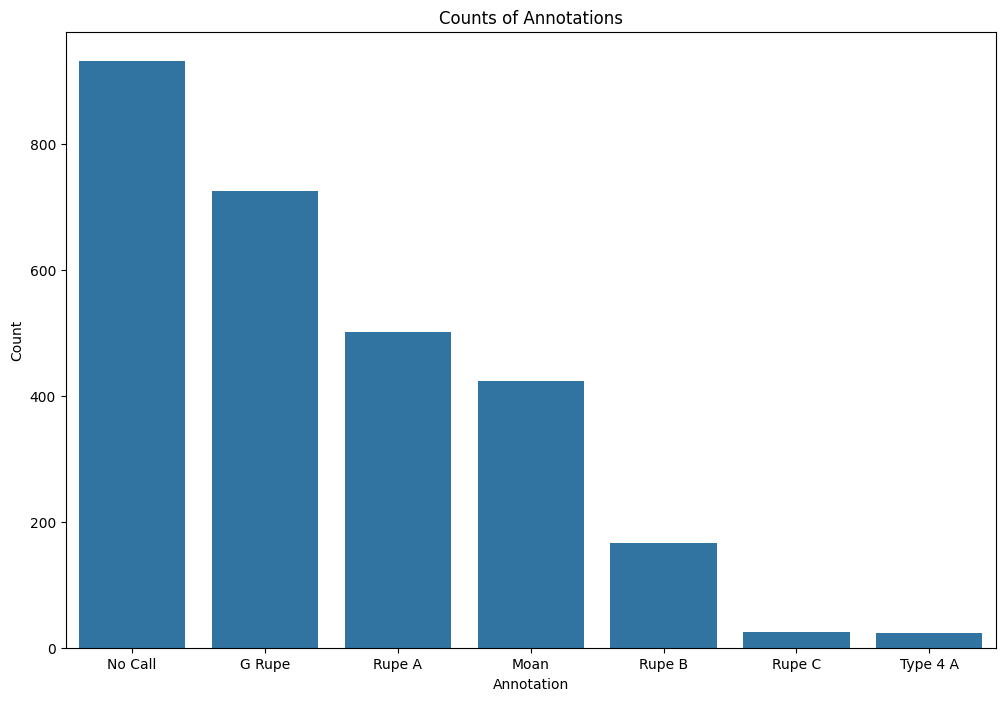

In [31]:
# Count the values
annotation_counts = df['Annotation'].value_counts()

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, ax=ax)

ax.set_xlabel("Annotation")
ax.set_ylabel("Count")
ax.set_title("Counts of Annotations")
plt.show()

The dataset is not balanced. Will stratify where possible.

### **1. Dataset Shaping & Spliting**

In [32]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

In [33]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    2796
Name: count, dtype: int64


In [34]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(2796,)
(2796, 42, 84)


In [35]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(2796, 42, 84)

In [36]:
X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

# First split: Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True
)

# Second split: Train/Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train.idxmax(axis=1),
    shuffle=True
)

# Output shapes
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

train_shape, val_shape, test_shape

((1677, 42, 84), (559, 42, 84), (560, 42, 84))

In [37]:
stratify_labels

0        Annotation_G Rupe
1        Annotation_G Rupe
2        Annotation_G Rupe
3        Annotation_G Rupe
4        Annotation_G Rupe
               ...        
2791    Annotation_No Call
2792    Annotation_No Call
2793    Annotation_No Call
2794    Annotation_No Call
2795    Annotation_No Call
Length: 2796, dtype: object

#### **Data Visualisation Functions**

Function to visualise the outputs later.

In [67]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_' + which], label='Validation Loss')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Accuracy')
    try:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

In [39]:
def confusion_matrix_plot():
    # Predict probabilities and convert to class predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert y_test one-hot to integer-encoded labels
    y_true = np.argmax(y_test, axis=1)

    # Extract the real class names
    class_names = [col.replace("Annotation_", "") for col in y_test.columns]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="viridis", ax=ax)

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

### **2. Model Selection & Evaluation**

Deciding on which machine learning algorithm looks to perform the best on the dataset

#### **Model 1: CNN**

In [40]:
input_shape = (42, 84, 1)
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),  # Add AUC for multi-class classification
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [43]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [44]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4816 - auc: 0.6369 - f1_score: 0.1228 - loss: 19.4249 - precision: 0.6008 - recall: 0.1708 - val_accuracy: 0.4762 - val_auc: 0.7792 - val_f1_score: 0.1220 - val_loss: 1.4206 - val_precision: 0.7671 - val_recall: 0.1667
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5402 - auc: 0.7382 - f1_score: 0.1630 - loss: 1.1823 - precision: 0.8856 - recall: 0.2351 - val_accuracy: 0.5089 - val_auc: 0.8233 - val_f1_score: 0.2278 - val_loss: 1.3012 - val_precision: 0.8547 - val_recall: 0.4375
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6542 - auc: 0.8294 - f1_score: 0.2499 - loss: 0.9748 - precision: 0.8890 - recall: 0.4279 - val_accuracy: 0.7202 - val_auc: 0.8550 - val_f1_score: 0.3827 - val_loss: 1.0606 - val_precision: 0.8405 - val_recall: 0.5804
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7096 - auc: 0.8593 - f1_score: 0.3688 - loss: 0.8820 - precision: 0.8445 - recall: 0.582

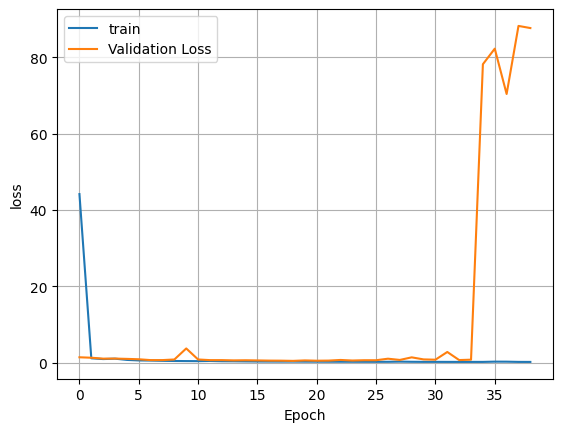

In [45]:
plot_loss(history)

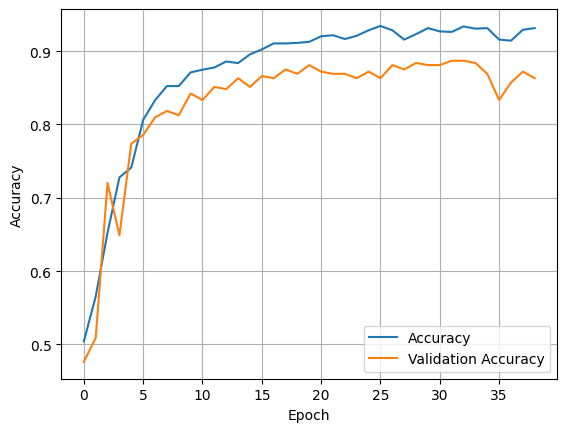

In [46]:
plot_accuracy(history)

In [47]:
model.evaluate(X_test, y_test, return_dict=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8912 - auc: 0.8905 - f1_score: 0.6146 - loss: 330.4335 - precision: 0.8989 - recall: 0.8875


{'accuracy': 0.8982142806053162,
 'auc': 0.9340096712112427,
 'f1_score': 0.6145930886268616,
 'loss': 174.8694610595703,
 'precision': 0.907608687877655,
 'recall': 0.8946428298950195}

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

      G Rupe       0.88      0.89      0.88       145
        Moan       0.82      0.82      0.82        85
     No Call       1.00      0.99      0.99       187
      Rupe A       0.83      0.99      0.90       100
      Rupe B       0.83      0.61      0.70        33
      Rupe C       0.00      0.00      0.00         5
    Type 4 A       0.00      0.00      0.00         5

    accuracy                           0.90       560
   macro avg       0.62      0.61      0.62       560
weighted avg       0.88      0.90      0.89       560



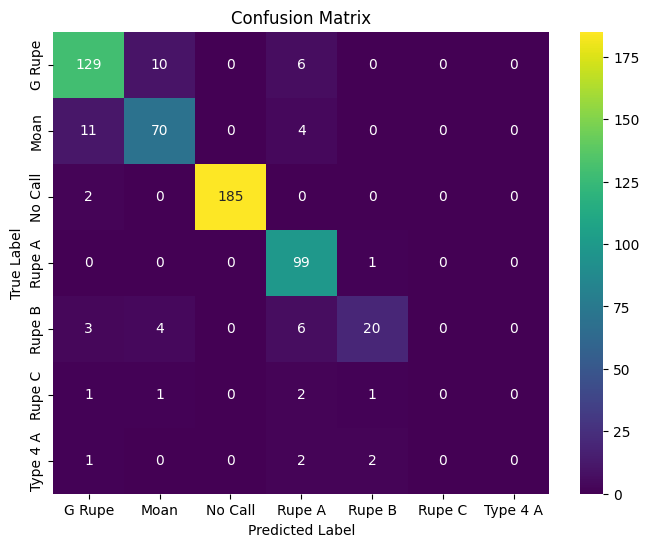

In [48]:
confusion_matrix_plot()

This simple CNN performed well although none of the minor annotation calls were found.

#### **Model 2: EfficientNet**

In [49]:
# Removed the data augmentation as the model is performing poorly.

# Training data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [50]:
# Add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [51]:
train_iterator = train_datagen.flow(X_train, y_train, batch_size=30, shuffle=True)
val_iterator = val_datagen.flow(X_val, y_val, batch_size=len(y_val), shuffle=True)
test_iterator = test_datagen.flow(X_test, y_test, batch_size=len(y_test), shuffle=True)

In [52]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the EfficientNetB4 base model
weights_path = 'noisy_student_efficientnet_b4.h5'

base_model = EfficientNetB4(
    weights=weights_path,
    include_top=False,
    pooling='avg',
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom top layers
model = keras.models.Sequential([
    base_model,                          # Add the base model
    #layers.Dropout(0.2),                 # Add Dropout
    layers.Dense(num_classes, activation='softmax')  # Add custom Dense layer for classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

# Display the model architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │        12,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,686,374 (67.47 MB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [53]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_EN.keras', monitor='val_loss', save_best_only=True)

In [54]:
history = model.fit(
    train_iterator,
    batch_size=32,
    epochs=20,
    validation_data=val_iterator,
    callbacks=[early_stop, callback_modelcheckpoint]
)

Epoch 1/20


c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.3038 - auc: 0.5317 - f1_score: 0.0718 - loss: 3.0988 - precision: 0.3330 - recall: 0.2813 - val_accuracy: 0.3327 - val_auc: 0.4889 - val_f1_score: 0.0718 - val_loss: 2.3014 - val_precision: 0.3357 - val_recall: 0.3327
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2767 - auc: 0.4890 - f1_score: 0.0704 - loss: 3.1060 - precision: 0.3015 - recall: 0.2460 - val_accuracy: 0.3417 - val_auc: 0.5130 - val_f1_score: 0.0747 - val_loss: 1.9852 - val_precision: 0.3432 - val_recall: 0.3327
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2817 - auc: 0.4485 - f1_score: 0.0651 - loss: 2.3572 - precision: 0.3143 - recall: 0.2561 - val_accuracy: 0.3578 - val_auc: 0.5212 - val_f1_score: 0.0758 - val_loss: 1.7988 - val_precision: 0.3535 - val_recall: 0.3238
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.3320 - auc: 0.4910 - f1_score: 0.0714 - loss: 2.0901 - precision: 0.3486 - recall: 0.2741 - val

In [55]:
saved_model = load_model('best_model_EN.keras')

In [56]:
saved_model.evaluate(test_iterator, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2304 - auc: 0.5591 - f1_score: 0.0000e+00 - loss: 1.6300 - precision: 0.0000e+00 - recall: 0.0000e+00


{'accuracy': 0.23035714030265808,
 'auc': 0.5590747594833374,
 'f1_score': 0.0,
 'loss': 1.6300362348556519,
 'precision': 0.0,
 'recall': 0.0}

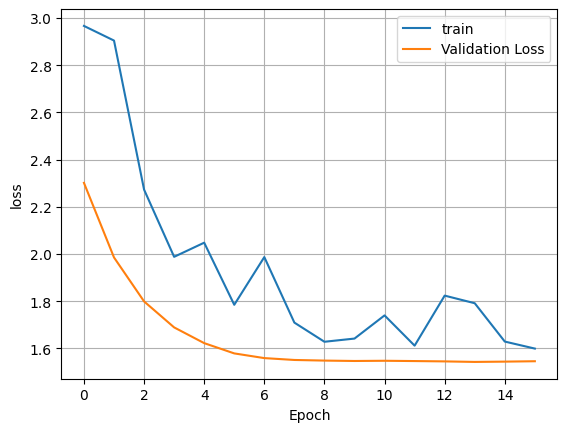

In [57]:
plot_loss(history)

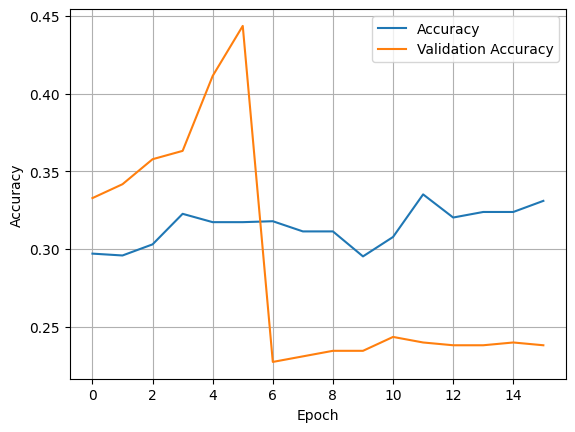

In [58]:
plot_accuracy(history)

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step
Classification Report:
              precision    recall  f1-score   support

      G Rupe       0.47      0.43      0.45       145
        Moan       0.00      0.00      0.00        85
     No Call       0.40      0.91      0.56       187
      Rupe A       0.00      0.00      0.00       100
      Rupe B       0.00      0.00      0.00        33
      Rupe C       0.00      0.00      0.00         5
    Type 4 A       0.00      0.00      0.00         5

    accuracy                           0.42       560
   macro avg       0.13      0.19      0.14       560
weighted avg       0.26      0.42      0.30       560



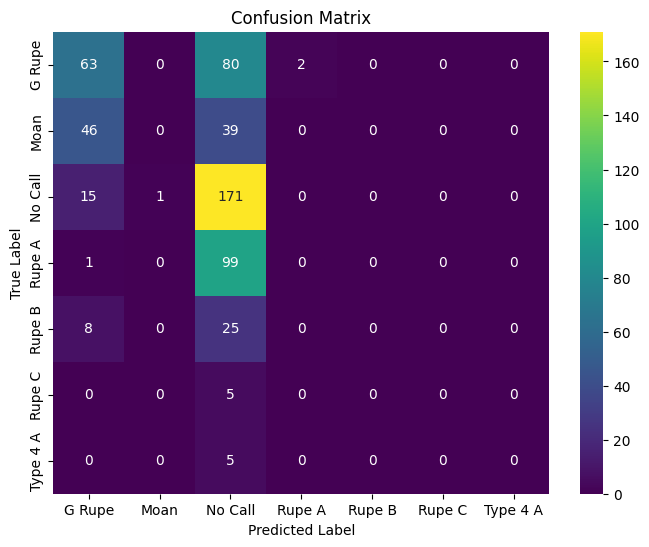

In [59]:
confusion_matrix_plot()

EfficientNet does not performs terribly. I adjusted numerous things but I could not get it to perform decent. This is odd and I cannot figure out why.

#### **Model 3:  Gradient Boosting**

In [60]:
# Flatten the 42×84 spectrogram into 42*84 = 3528 features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Train flattened shape: ", X_train_flat.shape)
print("Val flattened shape:   ", X_val_flat.shape)
print("Test flattened shape:  ", X_test_flat.shape)


Train flattened shape:  (1677, 3528)
Val flattened shape:    (559, 3528)
Test flattened shape:   (560, 3528)


In [61]:
y_train_idx = y_train.values.argmax(axis=1)
y_val_idx   = y_val.values.argmax(axis=1)
y_test_idx  = y_test.values.argmax(axis=1)

print("Train labels shape: ", y_train_idx.shape)
print("Val labels shape:   ", y_val_idx.shape)
print("Test labels shape:  ", y_test_idx.shape)


Train labels shape:  (1677,)
Val labels shape:    (559,)
Test labels shape:   (560,)


In [62]:
lgb_clf = LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    ensure_all_finite=True
)

lgb_clf.fit(
    X_train_flat,
    y_train_idx,
    eval_metric='multi_logloss'
)

[LightGBM] [Warning] Unknown parameter: ensure_all_finite


c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816919
[LightGBM] [Info] Number of data points in the train set: 1677, number of used features: 3528
[LightGBM] [Info] Start training from score -1.349416
[LightGBM] [Info] Start training from score -1.891372
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.717651
[LightGBM] [Info] Start training from score -2.819592
[LightGBM] [Info] Start training from score -4.716712
[LightGBM] [Info] Start training from score -4.785704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(ensure_all_finite=True, learning_rate=0.05, n_estimators=1000,
               num_class=7, objective='multiclass')

[LightGBM] [Warning] Unknown parameter: ensure_all_finite

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       145
           1       0.94      0.92      0.93        85
           2       1.00      1.00      1.00       187
           3       0.89      0.95      0.92       100
           4       0.74      0.79      0.76        33
           5       1.00      0.20      0.33         5
           6       0.00      0.00      0.00         5

    accuracy                           0.94       560
   macro avg       0.79      0.69      0.70       560
weighted avg       0.93      0.94      0.93       560



c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


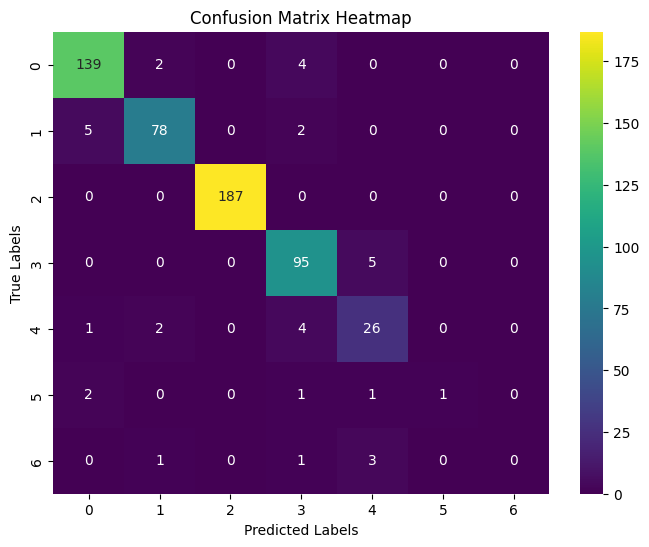

In [63]:
y_pred = lgb_clf.predict(X_test_flat)

print("\nClassification Report:")
print(classification_report(y_test_idx, y_pred, zero_division=0))

cm = confusion_matrix(y_test_idx, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Gradient Boosting LGBM performed extremely well considering that it is a simplier model. It detected one Rupe C call that the other models did not.

#### **Model 4: Support Vector Classifier**

In [64]:
# Convert one-hot-encoded y to integer class labels
y_train_labels = np.argmax(y_train.values, axis=1)
y_val_labels   = np.argmax(y_val.values,   axis=1)
y_test_labels  = np.argmax(y_test.values,  axis=1)


svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_flat, y_train_labels)


SVC(kernel='linear', random_state=42)

In [65]:
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_flat, y_train_labels)
y_pred = svm_clf.predict(X_test_flat)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       145
           1       0.76      0.74      0.75        85
           2       0.96      0.97      0.97       187
           3       0.79      0.94      0.86       100
           4       0.67      0.36      0.47        33
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5

    accuracy                           0.84       560
   macro avg       0.57      0.55      0.55       560
weighted avg       0.83      0.84      0.83       560



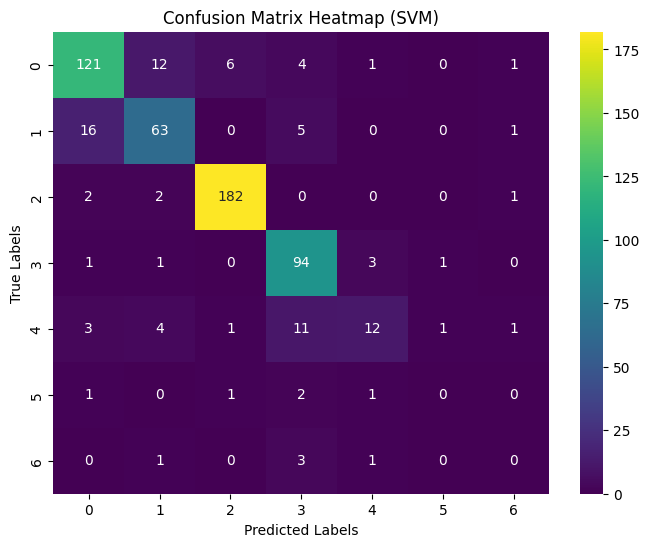

In [66]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, zero_division=0))

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Confusion Matrix Heatmap (SVM)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Support Vector Classifier perform decently but not as well as the Gradiant B or basic CNN.

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)
1.
1.
1.
1.
1.
1.
1.
1.





---

# END